In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from IPython.display import display, Math
import os

In [2]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d ajg117/indian-paintings-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/ajg117/indian-paintings-dataset
License(s): MIT
 77% 274M/355M [00:03<00:01, 81.5MB/s]
100% 355M/355M [00:03<00:00, 120MB/s] 


In [4]:
# Dataset path

DATA_DIR = "/content"

# Ignore unwanted folders
IGNORE_FOLDERS = {"sample_data", ".config"}

folders = [
    f.path for f in os.scandir(DATA_DIR)
    if f.is_dir() and f.name not in IGNORE_FOLDERS
]

print("Folders found:")
for f in folders:
    print(f, end= ', ')


# Collect image paths

SUPPORTED_EXT = ('.jpg', '.jpeg', '.png')

all_image_paths = []

for folder in folders:
    for file in os.listdir(folder):
        if file.lower().endswith(SUPPORTED_EXT):
            all_image_paths.append(os.path.join(folder, file))

print(f"\nTotal images found: {len(all_image_paths)}")
print(f"\nall_image_path: {all_image_paths[3]}")

# Sample a
random.seed(42)
NUM_IMAGES = 500
sampled_paths = random.sample(all_image_paths, min(NUM_IMAGES, len(all_image_paths)))
print(f"\nsampled_paths: {sampled_paths[3]}")

# Load & preprocess image

def load_image(path, size=(224,224)):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

sample_images_tensors = []
for p in sampled_paths:
    try:
        sample_images_tensors.append(load_image(p))
    except Exception as e:
        print(f"Skipping {p}: {e}")

print(f"Successfully loaded {len(sample_images_tensors)} images")
print(f"\nsample_images_tensors[3].shape: {sample_images_tensors[4].shape}")

Folders found:
/content/gond painting, /content/pichwai painting, /content/kerala mural, /content/warli painting, /content/kangra painting, /content/mandana art drawing, /content/madhubani painting, /content/kalighat painting, /content/.ipynb_checkpoints, 
Total images found: 924

all_image_path: /content/gond painting/gond26.jpg

sampled_paths: /content/kalighat painting/kalighat160.jpg
Skipping /content/kerala mural/kerala84.jpeg: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Successfully loaded 499 images

sample_images_tensors[3].shape: (224, 224, 3)


In [5]:
# Load pretrained CNN, hard coded layer_names

base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

layer_names = ['mixed3', 'mixed5', 'mixed7']

dream_model = tf.keras.Model(
    inputs=base_model.input,
    outputs=[base_model.get_layer(name).output for name in layer_names]
)

In [6]:
# loss, deep_dream, apply deep dreaming, resize, multioctane functions

# loss
def make_calc_loss(model):
    def calc_loss(img):
        img = tf.expand_dims(img, axis=0)
        activations = model(img)
        return tf.reduce_sum([tf.reduce_mean(act) for act in activations])
    return calc_loss

# deep_dream_step
@tf.function
def deepdream_step(img, step_size, calc_loss_fn):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss_fn(img)
    gradients = tape.gradient(loss, img)
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    img = img + gradients * step_size
    img = tf.clip_by_value(img, -1, 1)
    return img

# Apply deep dreming to the image

def apply_deepdream (img, steps, step_size, calc_loss_fn):
  img = tf.identity(original_img)
  for _ in range(steps):
    img = deepdream_step(img, step_size, calc_loss_fn)
  return img


In [7]:
  # Resizing function
  def resize_img(img, size):
    img = tf.expand_dims(img, axis=0)
    img = tf.image.resize(img, size)
    return tf.squeeze(img, axis=0)

# Multioctave  function
def run_deepdream_multioctave(
    img,
    calc_loss_fn,
    steps_per_octave=40,
    step_size=0.015,
    octaves=4,
    octave_scale=1.4
):
    img = tf.identity(img)

    base_shape = tf.shape(img)[:2]
    detail = tf.zeros_like(img)

    for octave in range(octaves):
        # Scale image down
        new_shape = tf.cast(
            tf.cast(base_shape, tf.float32) / (octave_scale ** (octaves - octave - 1)),
            tf.int32
        )

        img = tf.image.resize(img, new_shape)
        detail = tf.image.resize(detail, new_shape)

        # Add back details
        img += detail

        print(f"Octave {octave+1}/{octaves} | Shape: {new_shape.numpy()}")

        for _ in range(steps_per_octave):
            img = deepdream_step(img, step_size, calc_loss_fn)

        # Extract new details
        upscaled = tf.image.resize(img, base_shape) # img tensor is the result of the deep dream, this upscaled it
        detail = upscaled - tf.image.resize(img, base_shape) # difference between the upscaled img tensor vs the img tensor at the current octave

    return img

In [8]:
# Upload the image to deep dream

test_image_path = "/content/afgan.jpg"

# Load original
original_img = load_image(test_image_path)

In [9]:
# Inception-V3 DeepDream

calc_loss_base = make_calc_loss(dream_model)

dream_img_base = apply_deepdream(
    original_img,
    steps=300,
    step_size=0.02,
    calc_loss_fn=calc_loss_base
)

to_plot_base = apply_deepdream (original_img,
                 steps = 300,
                 step_size = 0.02,
                 calc_loss_fn = calc_loss_base)


In [10]:
# Layer selection based on activation strenghts

candidate_layers = [
    layer.name for layer in base_model.layers
    if "mixed" in layer.name
]

# Temporary model to extract activations

activation_model = tf.keras.Model(
    inputs=base_model.input,
    outputs=[base_model.get_layer(name).output for name in candidate_layers]
)

# Average activation strength on Indian paintings

activation_scores = {name: 0.0 for name in candidate_layers}

for img in sample_images_tensors:
    img = tf.expand_dims(img, axis=0)
    activations = activation_model(img)

    for name, act in zip(candidate_layers, activations):
        activation_scores[name] += tf.reduce_mean(act).numpy()

# Normalize
for k in activation_scores:
    activation_scores[k] /= len(sample_images_tensors)

# Select top-K layers

TOP_K = 3
selected_layers = sorted(
    activation_scores,
    key=activation_scores.get,
    reverse=True
)[:TOP_K]

print("Automatically selected layers:", selected_layers)


Automatically selected layers: ['mixed0', 'mixed1', 'mixed3']


In [11]:
# Make trainable the layers before the selected mixed layers

# Earliest selected mixed layer
layer_indices = [
    i for i, layer in enumerate(base_model.layers)
    if layer.name in selected_layers
]

start_index = min(layer_indices)
print("Unfreezing layers from index:", start_index)

# Freeze everything before the earliest important mixed

for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= start_index)


# Rebuild deep dream model

dream_model_2 = tf.keras.Model(
    inputs=base_model.input,
    outputs=[base_model.get_layer(name).output for name in selected_layers]
)

print("Trainable variables:", len(dream_model_2.trainable_variables))

Unfreezing layers from index: 40
Trainable variables: 36


In [12]:
# Fine-tuning loop- Indian Art

def indian_art_loss(activations):
    return tf.add_n([tf.reduce_mean(act) for act in activations])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        activations = dream_model_2(images)
        loss = -indian_art_loss(activations)
    gradients = tape.gradient(loss, dream_model_2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, dream_model_2.trainable_variables))
    return loss

In [13]:
# Run fine-tuning

BATCH_SIZE = 16

dataset = (
    tf.data.Dataset.from_tensor_slices(sample_images_tensors)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

for epoch in range(8):
    for batch in dataset:
        loss = train_step(batch)
    print(f"Epoch {epoch+1}, loss: {loss.numpy():.4f}")

Epoch 1, loss: -2.1390
Epoch 2, loss: -3.1596
Epoch 3, loss: -7.3535
Epoch 4, loss: -25.1549
Epoch 5, loss: -84.9235
Epoch 6, loss: -271.5613
Epoch 7, loss: -820.7274
Epoch 8, loss: -2385.4500


In [14]:
# Indian Art DeepDream

calc_loss_art = make_calc_loss(dream_model_2)

dream_img_art = apply_deepdream(
    original_img,
    steps=300,
    step_size=0.02,
    calc_loss_fn=calc_loss_art
)

to_plot_art = apply_deepdream (original_img,
                 steps = 300,
                 step_size = 0.02,
                 calc_loss_fn = calc_loss_art)

In [15]:
# Indian Art DeepDream stronger hallucinations

calc_loss_art = make_calc_loss(dream_model_2)

dream_art_strong = run_deepdream_multioctave(
    img=original_img,
    calc_loss_fn=calc_loss_art,
    steps_per_octave=35,
    step_size=0.018,
    octaves=4,
    octave_scale=1.35
)


Octave 1/4 | Shape: [91 91]
Octave 2/4 | Shape: [122 122]
Octave 3/4 | Shape: [165 165]
Octave 4/4 | Shape: [224 224]


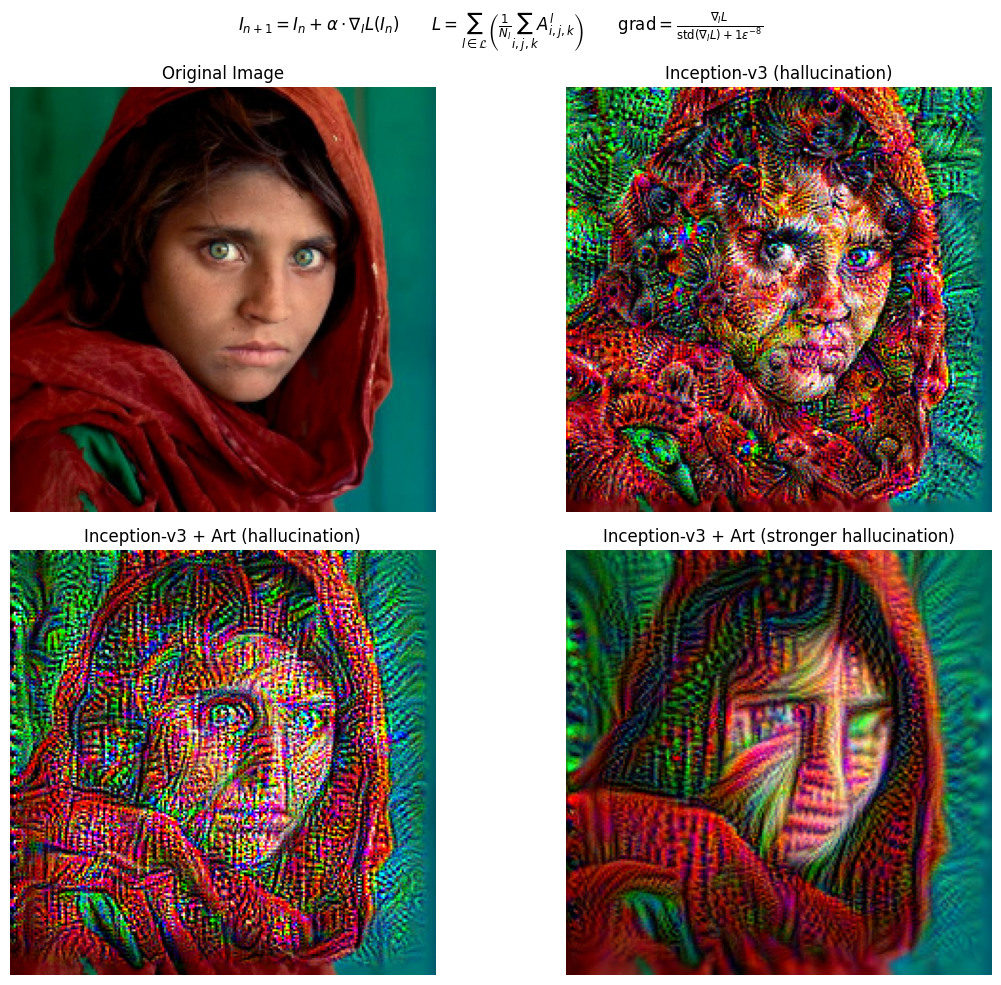

In [16]:
form_all = (
    r"$I_{n+1}=I_{n}+\alpha \cdot \nabla _{I}L(I_{n}) \qquad$"
    r"$L=\sum _{l\in \mathcal{L}}\left(\frac{1}{N_{l}}\sum _{i,j,k}A_{i,j,k}^{l}\right) \qquad$"
    r"$\text{grad}=\frac{\nabla _{I}L}{\text{std}(\nabla _{I}L)+1\epsilon ^{-8}}$"
)


def save_original_and_dream(original, dream, dream_2, dream_3, output_path):
    def deprocess(img):
        img = (img + 1.0) * 127.5
        return tf.cast(img, tf.uint8)

    plt.figure(figsize=(12,10))

    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(deprocess(original).numpy())
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.title("Inception-v3 (hallucination)")
    plt.imshow(deprocess(dream).numpy())
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.title("Inception-v3 + Art (hallucination)")
    plt.imshow(deprocess(dream_2).numpy())
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.title("Inception-v3 + Art (stronger hallucination)")
    plt.imshow(deprocess(dream_3).numpy())
    plt.axis("off")

    plt.gcf().text(0.5, 0.98, form_all, fontsize=12, ha='center', va='top')
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

    # Call save_original_and_dream
output_path = "/content/deepdream_comparison.jpg"
save_original_and_dream(original_img, to_plot_base, to_plot_art, dream_art_strong, output_path)